In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
import pypfopt
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import plotting
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel
from pypfopt import objective_functions

In [3]:
#import data 
stock_path = Path('../Resources/stock_prices.csv')
stock_prices = pd.read_csv(stock_path,parse_dates=True,index_col='Date',infer_datetime_format=True)

In [4]:
crypto_path = Path('../Resources/crypto_prices.csv')
crypto_prices = pd.read_csv(crypto_path,parse_dates=True,index_col='Date',infer_datetime_format=True)

In [5]:
prices=stock_prices.join(crypto_prices)
market_prices =prices["SPY"]
prices=prices.drop(columns="SPY")

In [6]:
#calculate mcap
mcaps_path = Path('../Resources/market_caps.csv')
mcaps = pd.read_csv(mcaps_path)
mcaps = dict(mcaps.values)
del mcaps['SPY']
mcaps

{'GME': 14821737472.0,
 'AMC': 7389094912.0,
 'TSLA': 582516000000.0,
 'BB': 4814926848.0,
 'NVDA': 374079000000.0,
 'BBBY': 2531467520.0,
 'MVIS': 2468789760.0,
 'BABA': 574829000000.0,
 'AMD': 94601461760.0,
 'BTC': 763196000000.0,
 'BCH': 15398498102.0,
 'ETH': 322857000000.0,
 'ETC': 8613669767.0,
 'LTC': 14169944716.0,
 'XRP': 54695173849.0,
 'DOGE': 51897302336.0}

3.5814245305272565

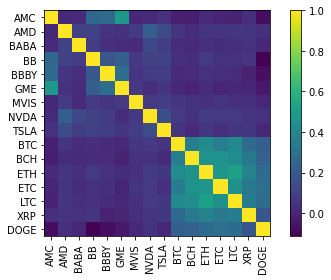

In [7]:
#Calculating the covariance matrix 
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

In [8]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMC     0.119993
AMD     0.332124
BABA    0.482378
BB      0.207036
BBBY    0.163940
GME     0.183613
MVIS    0.275904
NVDA    0.503221
TSLA    0.700524
BTC     1.157901
BCH     0.933709
ETH     1.106595
ETC     0.847919
LTC     0.934931
XRP     0.884940
DOGE    1.088490
dtype: float64

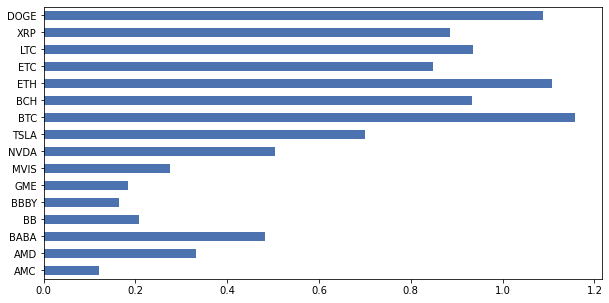

In [9]:
market_prior.plot.barh(figsize=(10,5));

In [10]:
# BTC will rise by 10%
# GME will outperfrom NVDA by 20%
# ETH will outperform ETC by 5%
# BB will fall 20%
Q = np.array([0.1, 0.2, 0.05, 0.2]).reshape(-1, 1)
P = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,0],
        [0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0,0],
        [0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ]
)
confidences=[0.6,0.4,0.3,0.2]

In [11]:
bl = BlackLittermanModel(S, pi=market_prior, omega="idzorek", view_confidences=confidences,Q = Q,P = P)

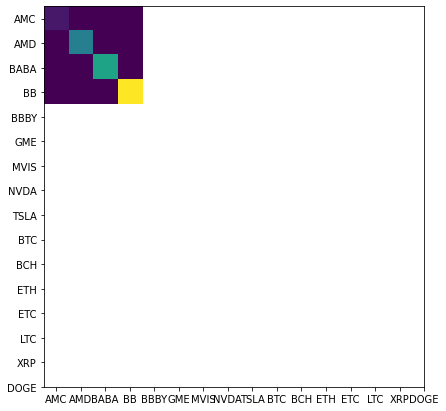

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [13]:
ret_bl = bl.bl_returns()
ret_bl

AMC     0.211630
AMD     0.295700
BABA    0.465005
BB      0.192077
BBBY    0.134683
GME     0.326357
MVIS    0.220357
NVDA    0.423363
TSLA    0.664406
BTC     0.520891
BCH     0.591399
ETH     0.764825
ETC     0.594190
LTC     0.599540
XRP     0.631717
DOGE    0.769755
dtype: float64

In [14]:
rets_df = pd.DataFrame([market_prior, ret_bl], 
             index=["Prior", "Posterior"]).T
rets_df

,Prior,Posterior
AMC,0.119993,0.211630
AMD,0.332124,0.295700
BABA,0.482378,0.465005
BB,0.207036,0.192077
BBBY,0.163940,0.134683
GME,0.183613,0.326357
MVIS,0.275904,0.220357
NVDA,0.503221,0.423363
TSLA,0.700524,0.664406
BTC,1.157901,0.520891


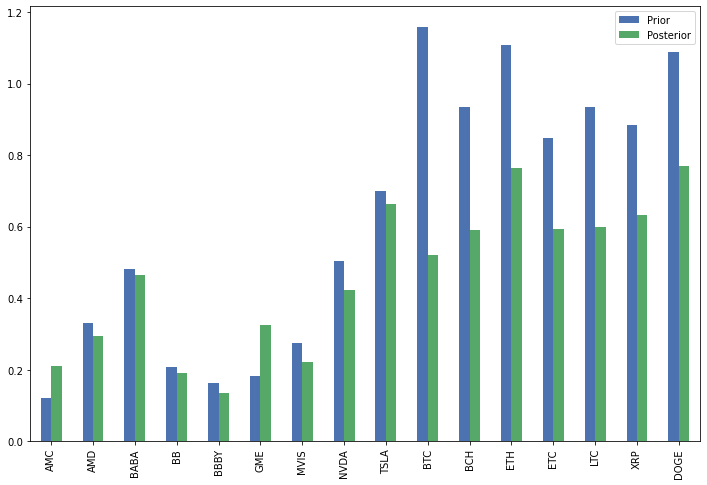

In [15]:
rets_df.plot.bar(figsize=(12,8));

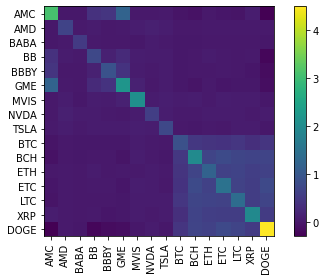

In [16]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Max Sharpe Ratio

In [17]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/weirongtian/opt/anaconda3/envs/deeplearnenv/lib/python3.7/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:248: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AMC', 0.00946),
             ('AMD', 0.05808),
             ('BABA', 0.1525),
             ('BB', 0.02382),
             ('BBBY', 0.00581),
             ('GME', 0.04158),
             ('MVIS', 0.01469),
             ('NVDA', 0.1093),
             ('TSLA', 0.19151),
             ('BTC', 0.07672),
             ('BCH', 0.02865),
             ('ETH', 0.11277),
             ('ETC', 0.04219),
             ('LTC', 0.04218),
             ('XRP', 0.04909),
             ('DOGE', 0.04166)])

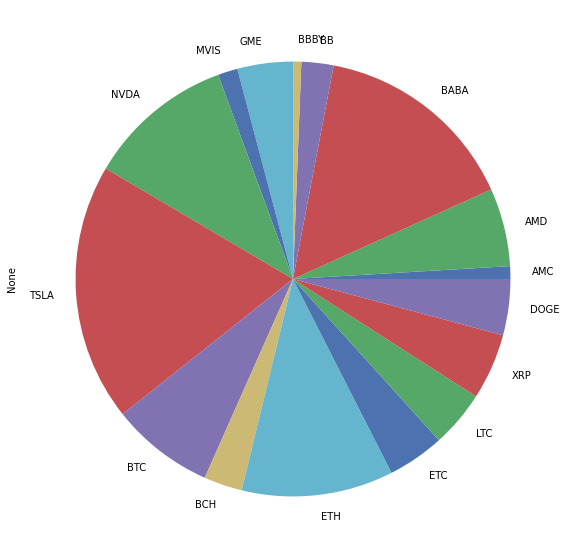

In [18]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [19]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(ret_bl)), n_samples)
rets = w.dot(ret_bl)
stds = np.sqrt((w.T * (S_bl @ w.T)).sum(axis=0))
sharpes = rets / stds

TypeError: can't pickle osqp.OSQP_results objects

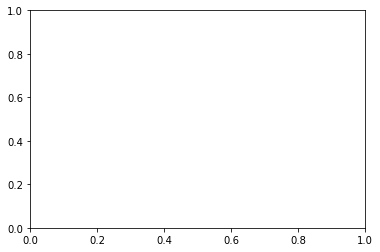

In [20]:
# Plot efficient frontier with Monte Carlo sim
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

## Maximum return given risk

In [21]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.efficient_risk(target_volatility=0.6)
ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
weights = ef.clean_weights()
weights

OrderedDict([('AMC', 0.0),
             ('AMD', 0.0),
             ('BABA', 0.16532),
             ('BB', 0.0),
             ('BBBY', 0.0),
             ('GME', 0.0),
             ('MVIS', 0.0),
             ('NVDA', 0.0),
             ('TSLA', 0.43334),
             ('BTC', 0.0),
             ('BCH', 0.0),
             ('ETH', 0.31896),
             ('ETC', 0.0),
             ('LTC', 0.0),
             ('XRP', 0.02755),
             ('DOGE', 0.05482)])

In [ ]:
pd.Series(weights).plot.pie(figsize=(10,10));

## Minimum risk given return

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(0,1))
ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
ef.efficient_return(target_return=0.7)
weights = ef.clean_weights()
weights

In [ ]:
pd.Series(weights).plot.pie(figsize=(10, 10));